In [1]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow as tf

In [2]:
df = pd.read_csv("train.csv")
base_path = "C:/Users/nakul/OneDrive/Pictures/landmark"



In [3]:
df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [4]:
df = df.loc[df["id"].str.startswith(("00"), na = False),:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [5]:
num_classes

5346

In [6]:
num_data


6120

In [7]:
data = pd.DataFrame(df["landmark_id"].value_counts())
data.reset_index(inplace=True)
data.head()

,landmark_id,count
0,138982,31
1,83144,14
2,126637,7
3,194914,7
4,109169,6


In [8]:
data.tail()

,landmark_id,count
5341,71434,1
5342,71336,1
5343,71228,1
5344,71145,1
5345,202981,1


In [9]:
data.columns=['landmark_id','count']

In [10]:
data['count'].describe()

count    5346.000000
mean        1.144781
std         0.641260
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        31.000000
Name: count, dtype: float64

(array([0.000e+00, 0.000e+00, 0.000e+00, 4.781e+03, 0.000e+00, 0.000e+00,
        4.520e+02, 0.000e+00, 0.000e+00, 7.500e+01, 0.000e+00, 0.000e+00,
        2.200e+01, 0.000e+00, 0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

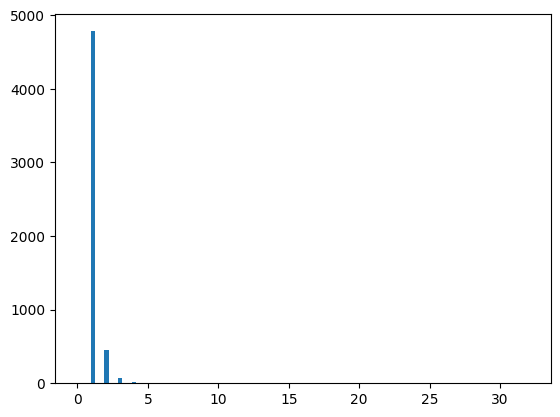

In [11]:
plt.hist(data['count'], 100, range = (0,32), label = 'test')

In [12]:
data['count'].between(0,5).sum()

5339

In [13]:
data['count'].between(5,10).sum()

14

(array([2., 1., 1., ..., 1., 1., 2.]),
 array([2.70000e+01, 6.00000e+01, 1.24000e+02, ..., 2.02950e+05,
        2.02972e+05, 2.02981e+05]),
 <BarContainer object of 5345 artists>)

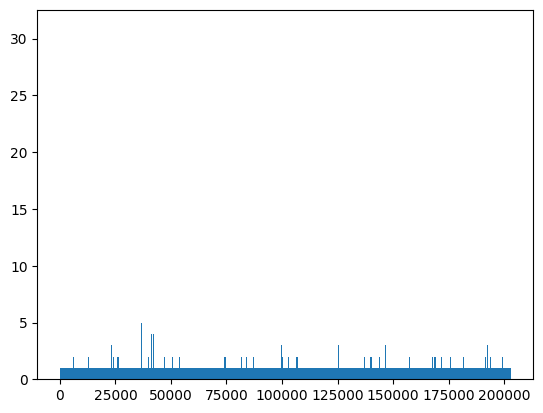

In [14]:
plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())

In [15]:
#training starts now
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [16]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [17]:
def encode_label(lbl):
    return lencoder.transform(lbl)

In [18]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [19]:
def get_image_from_number(num, df):
    fname, label = df.iloc[num, :]
    fname = fname +'.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

4 sample images from random classes generated


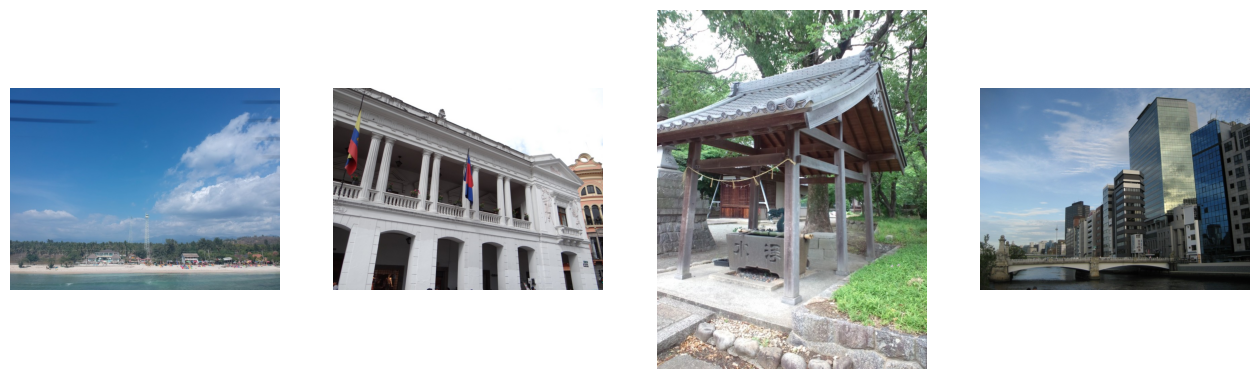

In [20]:
print("4 sample images from random classes generated")
fig = plt.figure(figsize=(16,16))
for i in range (1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [22]:
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
tf.compat.v1.disable_eager_execution()

In [23]:
learning_rate = 0.0001
decay_speed   = 1e-6
momentum      = 0.09
loss_function = "sparse_categorical_crossentropy"
source_model  = VGG19(weights=None)
drop_layer    = Dropout(0.5)
drop_layer2   = Dropout(0.5)

In [24]:
model = Sequential()
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,8

 Total params: 161,472,814 (615.97 MB)

 Trainable params: 161,472,808 (615.97 MB)

 Non-trainable params: 6 (24.00 B)

In [27]:
from keras.optimizers import RMSprop
optim1 = RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optim1,
              loss = loss_function,
              metrics = ["accuracy"])

In [28]:
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

In [53]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []
    
    end_img = start + batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
        
    for idx in range(start, end_img):
        im, label = get_image_from_number(idx, dataframe)
        
        # Ensure image is correctly reshaped to (224, 224, 3)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        
        # Append label correctly
        label_array.append(label)
    
    # Encode labels
    label_array = encode_label(label_array)
    
    return np.array(image_array), np.array(label_array)


In [54]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

train, val = np.split(df.sample(frac=1),[int(0.8*len(df))])
print(len(train))
print(len(val))

4896
1224


C:\Users\nakul\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size
        self.indices = np.arange(len(data))
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_train, y_train = self.get_batch(batch_indices)
        return np.asarray(X_train, dtype=np.float32), np.asarray(y_train, dtype=np.float32)

    def get_batch(self, batch_indices):
        # Replace this with your logic to retrieve the batch from self.data
        # For example:
        return self.data.iloc[batch_indices].drop('target_column', axis=1).values, self.data.iloc[batch_indices]['target_column'].values

# Training loop
for e in range(epochs):
    print("Epoch: " + str(e + 1) + "/" + str(epochs))
    
    # Create Data Generator
    train_generator = DataGenerator(train, batch_size)
    
    # Fit model on the generator
    model.fit(train_generator, epochs=1, verbose=0)

model.save("Model")


Epoch: 1/10


KeyError: "['target_column'] not found in axis"